### Edge Detection Section ###

Corresponding to section 2.4 of the report. Starring Rojas (who was also not harmed in the making of this project), and a toy dinosaur.

In [ ]:
# import packages
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature
from skimage.filters import sobel_h, sobel_v, sobel
import numpy as np
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from tqdm import tqdm
from skimage.feature import canny
from scipy.ndimage import binary_dilation


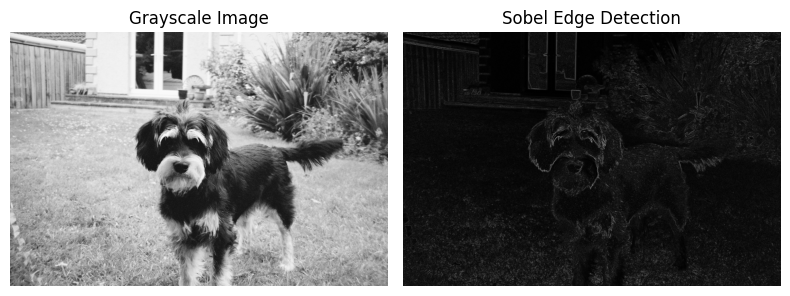

In [ ]:
# sobel edge detection

# load image
image_path = "IMG_5643.jpeg"
image_rgb = io.imread(image_path)

# convert to grayscale
image_gray = color.rgb2gray(image_rgb)

# apply Sobel operator manually
I_x = sobel_h(image_gray)  # horizontal gradient (Sx)
I_y = sobel_v(image_gray)  # vertical gradient (Sy)

# compute gradient magnitude
gradient_magnitude = np.sqrt(I_x**2 + I_y**2)

# plot comparison
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[0].axis('off')

ax[1].imshow(filters.sobel(image_gray), cmap='gray')
ax[1].set_title('Sobel Edge Detection')
ax[1].axis('off')

plt.tight_layout()
plt.show()

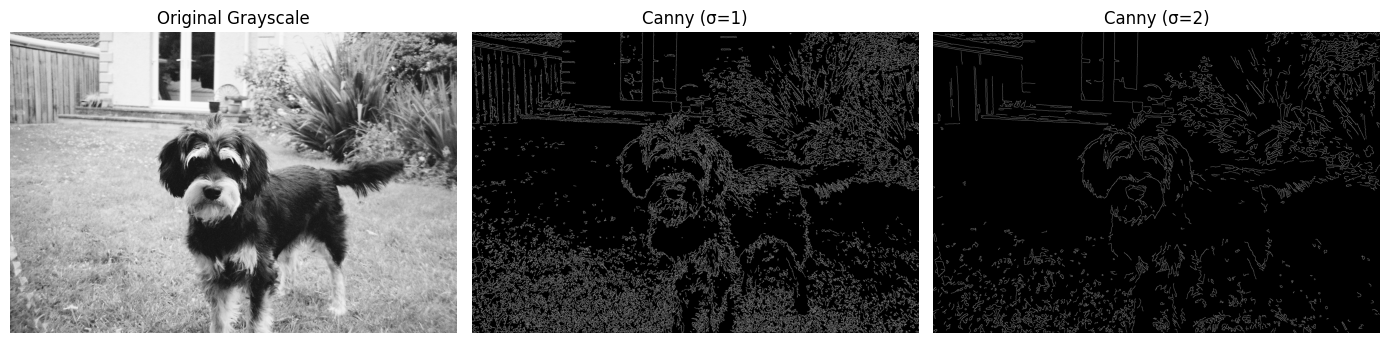

In [8]:
# canny edge detection

# define different Gaussian smoothing levels
sigma_values = [1, 2]

# perform Canny edge detection for each sigma
edges = []
for sigma in sigma_values:
    edges.append(feature.canny(image_gray, sigma=sigma, low_threshold=0.15, high_threshold=0.3))

# plot comparison
fig, axes = plt.subplots(1, len(sigma_values) + 1, figsize=(14, 5))
ax = axes.ravel()

# original grayscale image
ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Original Grayscale')
ax[0].axis('off')

# each Canny result
for i, sigma in enumerate(sigma_values):
    ax[i + 1].imshow(edges[i], cmap='gray')
    ax[i + 1].set_title(f'Canny (σ={sigma})')
    ax[i + 1].axis('off')

plt.tight_layout()
plt.show()

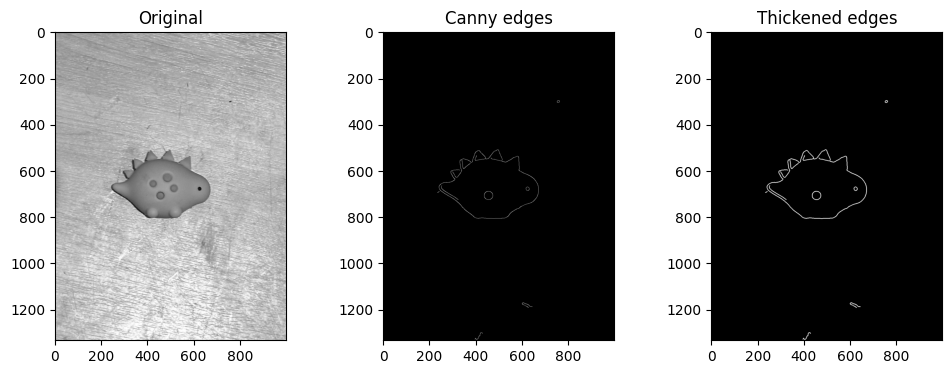

Alpha loop: 100%|██████████| 5/5 [08:49<00:00, 105.99s/it]


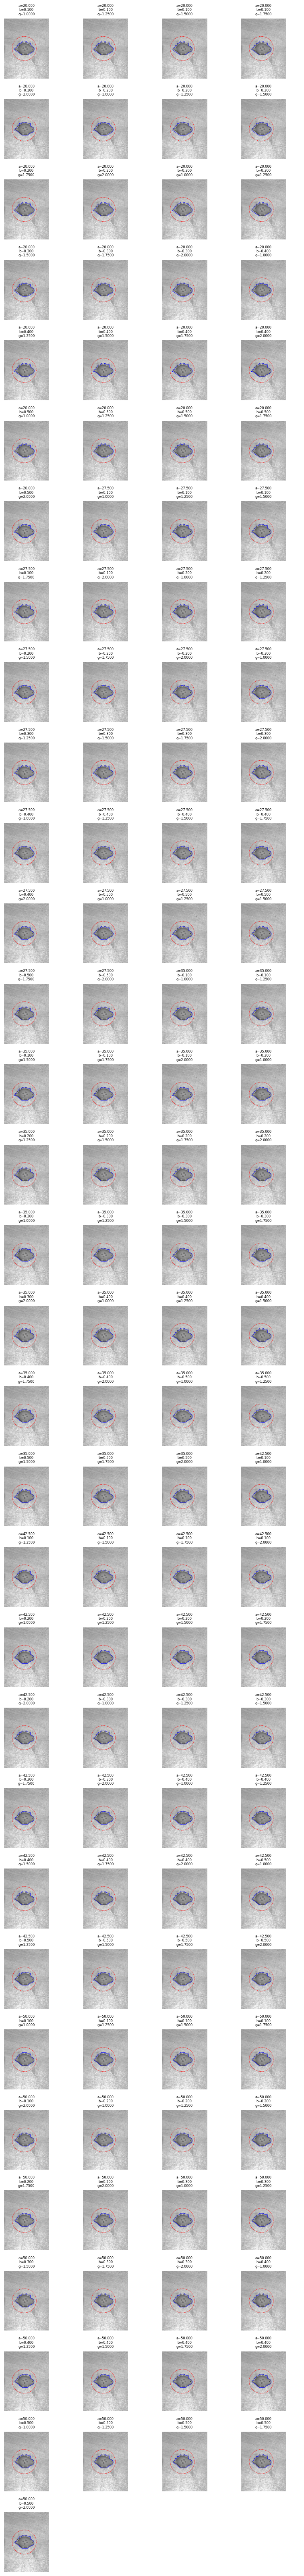

In [ ]:
# active contour

# load the image
img_path = "IMG_6285.jpeg"
img_rgb = io.imread(img_path)
img = rgb2gray(img_rgb)
rows, cols = img.shape

# initial circular contour
r_center, c_center = rows * 0.5, cols * 0.45
radius = min(rows, cols) * 0.27
s = np.linspace(0, 2 * np.pi, 1000)
r = r_center + radius * np.sin(s)
c = c_center + radius * np.cos(s)

# clip the circle so it stays inside the image
init = np.array([r, c]).T

# preprocess
smoothed = gaussian(img, sigma=3)

# strong edge map
edges = canny(smoothed, sigma=2.0)

# thicken edges
edges_thick = binary_dilation(edges, iterations=1)

# convert to energy for the snake
energy = -edges_thick.astype(float)

# parameter ranges
alphas = np.linspace(20, 50, 5)
betas  = np.linspace(0.1, 0.5, 5)
gammas = np.linspace(1, 2, 5)

# store results
results = {}

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(edges, cmap='gray'); plt.title("Canny edges")
plt.subplot(1, 3, 3); plt.imshow(edges_thick, cmap='gray'); plt.title("Thickened edges")
plt.show()


# triple grid search
for alpha in tqdm(alphas, desc="Alpha loop"):
    for beta in betas:
        for gamma in gammas:

            snake = active_contour(
                energy,
                init,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                w_line=0,
                w_edge=55
            )

            results[(alpha, beta, gamma)] = snake

n = len(results)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for ax, ((alpha, beta, gamma), snake) in zip(axes, results.items()):
    ax.imshow(img, cmap='gray')
    ax.plot(init[:, 1], init[:, 0], '--r', lw=0.5)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=0.5)
    ax.set_title(f"a={alpha:.3f}\nb={beta:.3f}\ng={gamma:.4f}", fontsize=6)
    ax.axis("off")

for i in range(len(results), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

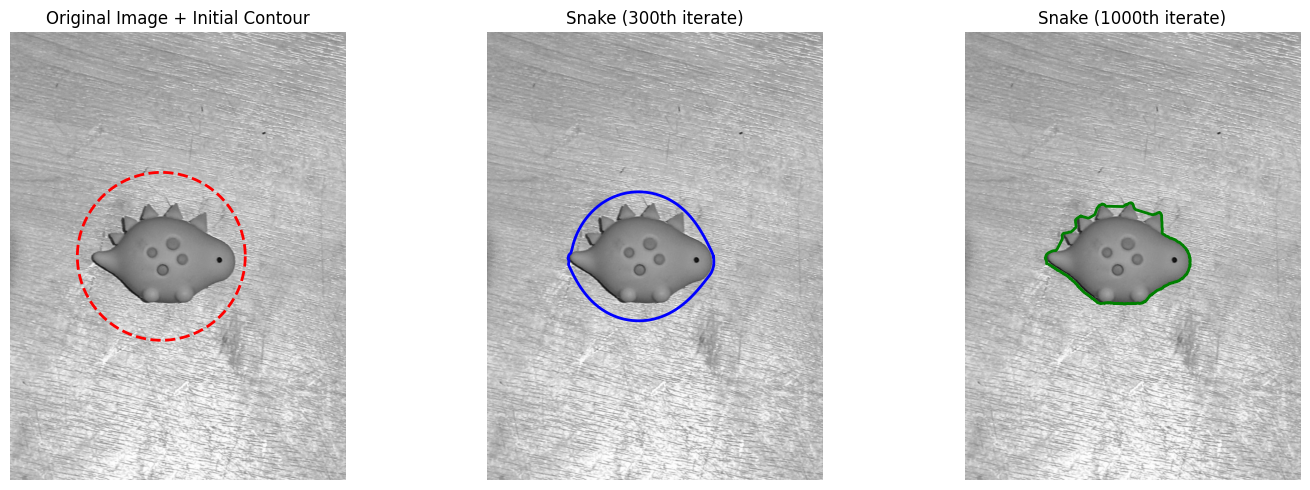

In [ ]:
# load the image
img_path = "IMG_6285.jpeg"
img_rgb = io.imread(img_path)
img = rgb2gray(img_rgb)

rows, cols = img.shape

# initial circular contour
r_center, c_center = rows * 0.5, cols * 0.45
radius = min(rows, cols) * 0.25
s = np.linspace(0, 2 * np.pi, 1000)
r = r_center + radius * np.sin(s)
c = c_center + radius * np.cos(s)
init = np.array([r, c]).T

# preprocess
smoothed = gaussian(img, sigma=3)

# edge map
edges = canny(smoothed, sigma=2.0)
edges_thick = binary_dilation(edges, iterations=1)
energy = -edges_thick.astype(float)

# parameters
alpha, beta, gamma = 45, 0.08, 2


# run snake with limited iterations to capture mid-way
snake_mid = active_contour(
    energy, init,
    alpha=alpha, beta=beta, gamma=gamma, w_edge=55
    ,max_num_iter=300  # mid-way
)

snake_final = active_contour(
    energy, init,
    alpha=alpha, beta=beta, gamma=gamma,
    w_edge=55,
    max_num_iter=2000
)

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].plot(init[:, 1], init[:, 0], '--r', lw=2)
axes[0].set_title("Original Image + Initial Contour")
axes[0].axis("off")

axes[1].imshow(img, cmap='gray')
axes[1].plot(snake_mid[:, 1], snake_mid[:, 0], '-b', lw=2)
axes[1].set_title("Snake (300th iterate)")
axes[1].axis("off")

axes[2].imshow(img, cmap='gray')
axes[2].plot(snake_final[:, 1], snake_final[:, 0], '-g', lw=2)
axes[2].set_title("Snake (1000th iterate)")
axes[2].axis("off")

plt.tight_layout()
plt.show()